### Import modules

In [103]:
import numpy as np
from tqdm import trange
from functools import partial
import pickle as pkl

from matplotlib import pyplot as plt
from labellines import labelLines,labelLine

import networkx as nx


from graph_bandit_helper_tools import return_graph
from core import train_agent
from agents import doubling_agent

%load_ext autoreload
%autoreload 2

SEED = 181732

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tests

In [6]:
def delta_test(Delta, n_nodes=10, graph_type='line', n_samples=100, T=450):
    np.random.seed(SEED)
    G = return_graph(graph_type, n_nodes)
    
    means = np.zeros((n_samples, n_nodes))
    means[:,0] = [9.5-Delta for _ in range(n_samples)]
    means[:,-1] = [9.5 for _ in range(n_samples)]
    
    regrets = train_agent(n_samples,T,G,means,init_node,doubling_agent,parallelized=True)
    return regrets

    
    

In [97]:
def num_nodes_test(Delta, n_nodes=10, graph_type='star', n_samples=100, T=450):
    G = return_graph(graph_type, n_nodes)
    print(len(G))
    
    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    regrets = train_agent(n_samples,T,G,means,init_node,doubling_agent,parallelized=True)
    return regrets

    
    

In [229]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    
    plt.style.use('seaborn-whitegrid')
    # sns.set()
    
    keys = allRegrets[0].keys()
    colors=['b', 'r', 'g', 'm', 'b', 'r', 'g', 'm', 'g', 'c', 'k', 'b', 'r', 'y', 'm', 'g','b']
    styles = ['solid', 'solid', 'solid', 'solid', 'dotted', 'dotted', 'dotted', 'dotted', 'dotted','dotted']

    

    if nPlots == 1:
        regrets = allRegrets[0]
        for j, key in enumerate(keys):
            
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            
            sd = np.std(regret,axis=0)
            regret = np.mean(regret,axis=0)

            # plt.errorbar(range(1,len(regret)+1), regret ,sd,errorevery=200,\
            #              c=colors[j], linestyle = styles[j], linewidth=5,\
            #             capsize=5,elinewidth=2)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[j], linestyle = styles[j], label=key,\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])

        
    plt.xlabel('$t$', fontsize=25,weight='bold')
    plt.ylabel('Regret', fontsize=25,weight = 'bold')
    plt.tick_params(labelsize=25)
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    # plt.show()
    
    

# Dependence on $\Delta$ 

In [184]:
delta_regrets = {}
delta_regrets['$\Delta=2$'] = delta_test(2, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=1$'] = delta_test(1, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=0.5$'] = delta_test(0.5, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=0.25$'] = delta_test(0.25, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-1}$'] = delta_test(0.1, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-2}$'] = delta_test(0.01, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-3}$'] = delta_test(0.001, n_nodes=10, graph_type='line', n_samples=100, T=1000)
delta_regrets['$\Delta=10^{-4}$'] = delta_test(0.0001, n_nodes=10, graph_type='line', n_samples=100, T=1000)

In [185]:
with open('Data/delta_test.pkl', 'wb') as file:
    pkl.dump(delta_regrets,file)

In [186]:
with open('Data/delta_test.pkl', 'rb') as file:
    delta_regrets = pkl.load(file)

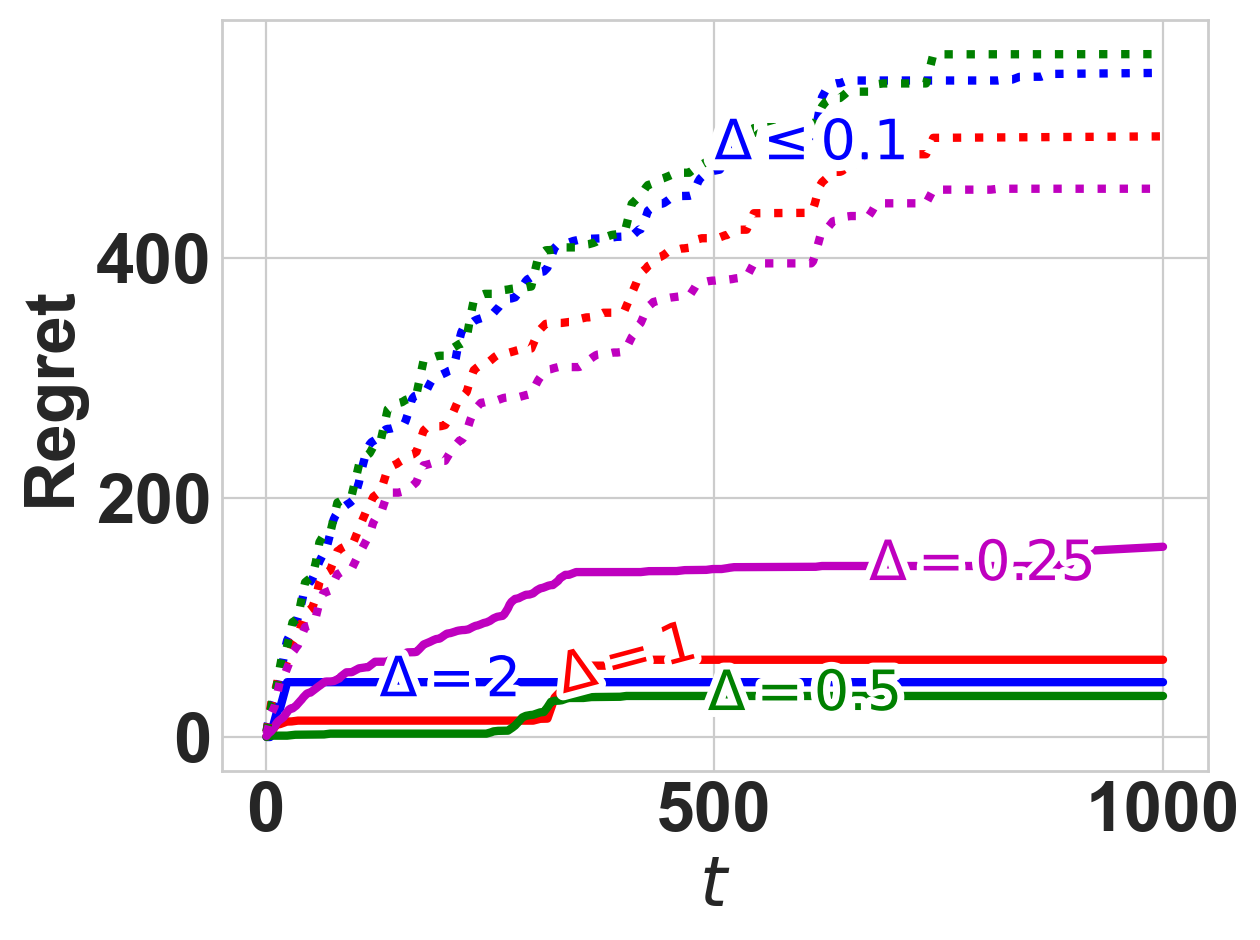

In [230]:

plt.rc('font', weight='bold')
plt.figure(dpi=200)

plotRegrets([delta_regrets])

lines = plt.gca().get_lines()

labelLine(
    lines[-4],
    500,
    label=r"$\Delta\leq 0.1$",
    ha="left",
    va="bottom",
    align=False,
    yoffset = 0,
    backgroundcolor="none",
   fontsize = 20
)


labelLines(lines[:-4],align=True, zorder=2.5,fontsize=20)


plt.tight_layout()
plt.savefig('Figures/delta_test.png',bbox_inches = 'tight')
plt.show()

# Dependence on $|S|$

In [188]:
nodes_regrets = {}

In [189]:
Ns = [11,51,101,201,501,1001]
n_samples = 100
T = 1000

np.random.seed(SEED)
for n_nodes in Ns:
    nodes_regrets['$|S|={}$'.format(n_nodes)] = num_nodes_test(0.01, n_nodes=n_nodes, graph_type='star', n_samples=n_samples, T=T)

11
51
101
201
501
1001


In [190]:
with open('Data/num_node_test.pkl', 'wb') as file:
    pkl.dump(nodes_regrets,file)

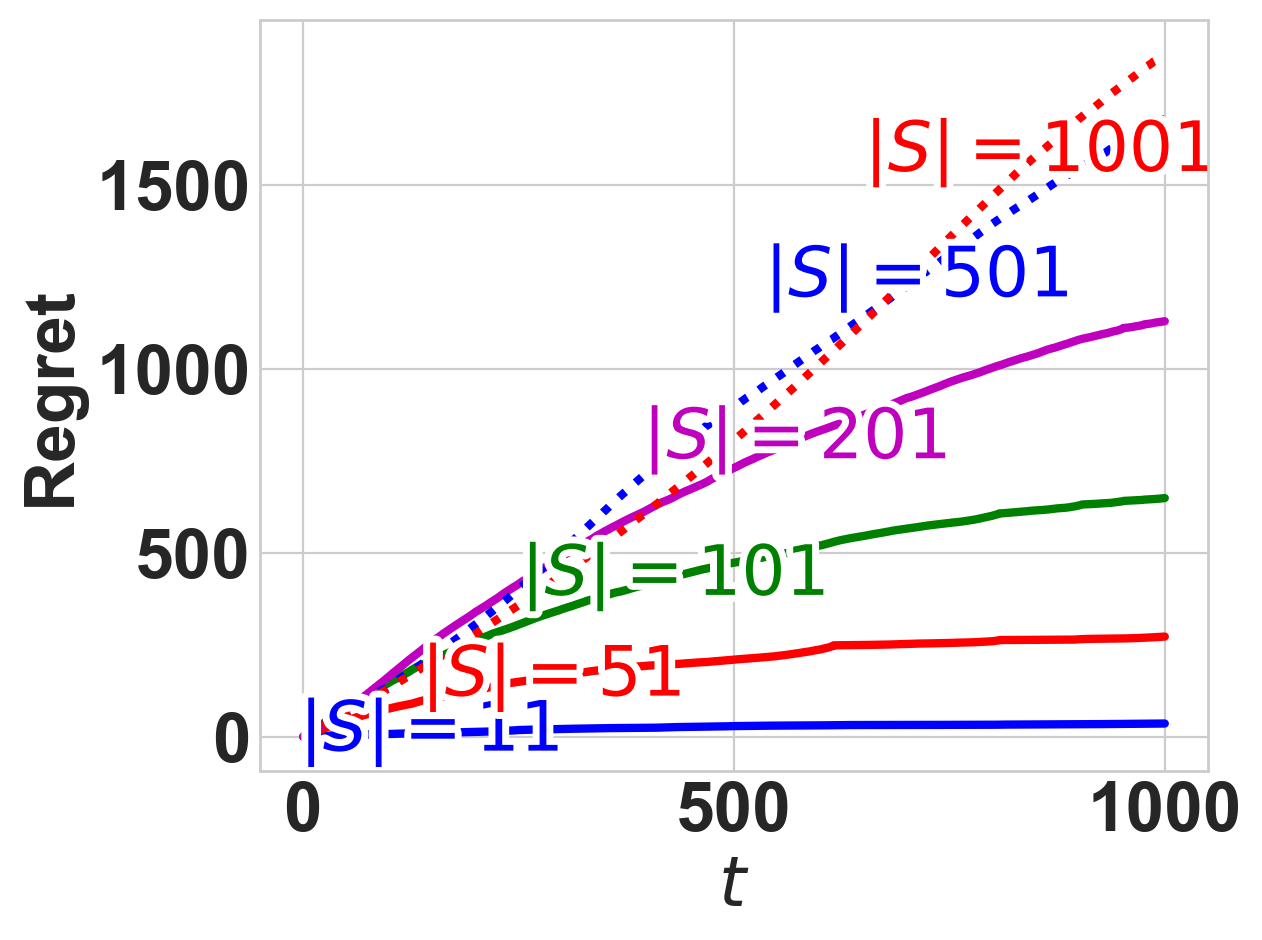

In [228]:

plt.rc('font', weight='bold')
plt.figure(dpi=200)
plotRegrets([nodes_regrets])

lines = plt.gca().get_lines()

labelLines(lines[:],align=False, zorder=2.5,fontsize=25)
plt.tight_layout()
plt.savefig('Figures/num_node_test.png')
plt.show()

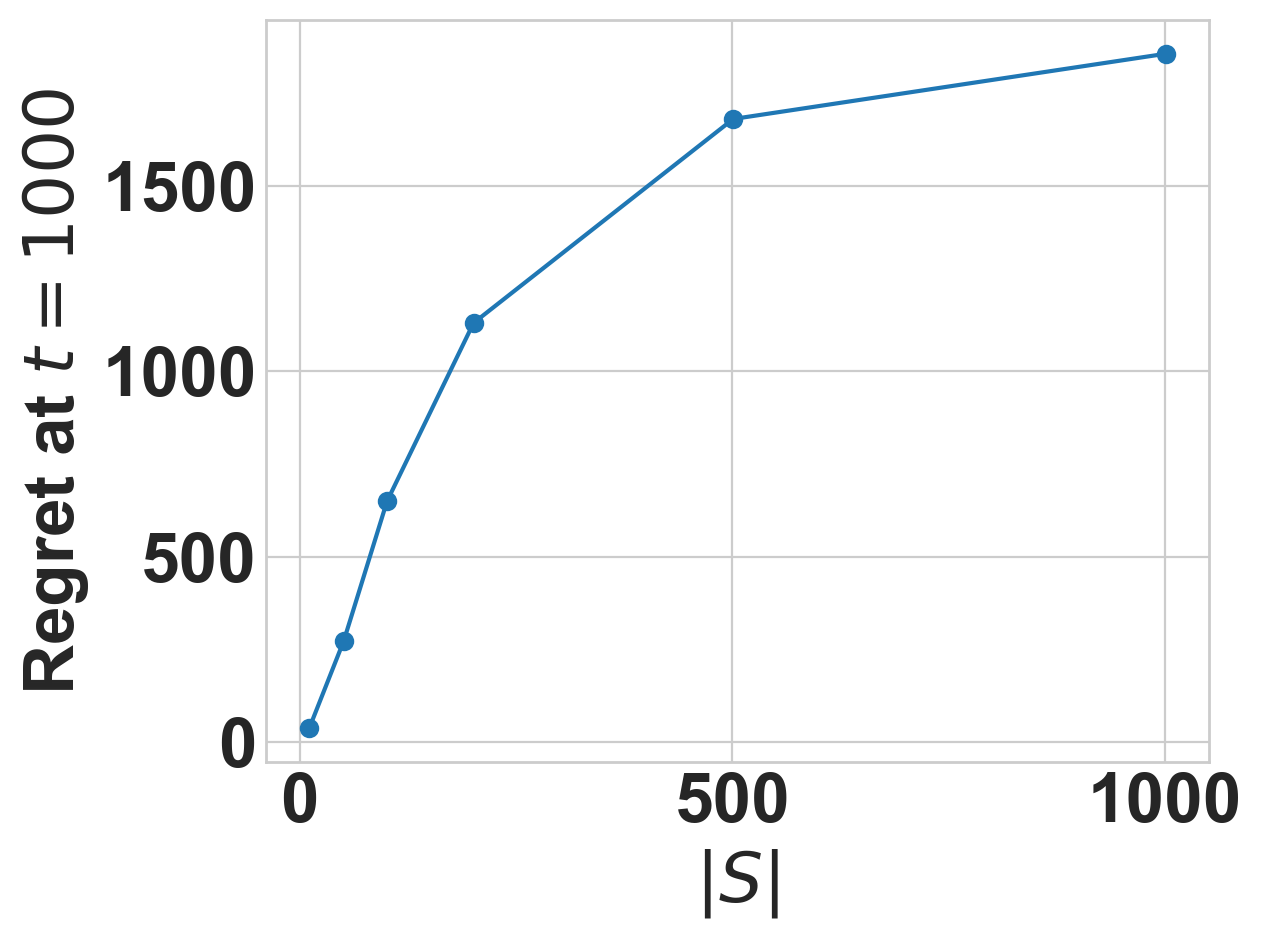

In [238]:
num_nodes = Ns

reg = [nodes_regrets["$|S|={}$".format(n)] for n in num_nodes]

reg = np.cumsum(reg, axis=2)
reg = np.mean(reg, axis=1)


plt.rc('font', weight='bold')
plt.figure(dpi=200)

plt.plot(num_nodes,reg[:,-1],marker='o')
plt.xlabel(r"$|S|$",fontsize=25,weight='bold')
plt.ylabel(r'Regret at $t=1000$',fontsize=25,weight='bold')
plt.tick_params(labelsize=25)

plt.tight_layout()
plt.savefig('Figures/RvsS.png')

# Dependence on $D$

In [207]:
# Fixed diameter graphs
def fix_diameter_graph(N,D):
    assert(D<=N)
    
    if D==1:
        return return_graph('fully_connected',N)
    
    G = return_graph('line',D)
    G.add_edges_from([(D-1, i+D) for i in range(N-D)])
    G.add_edges_from([(i,i) for i in G])
    return G

In [232]:
reg = {}

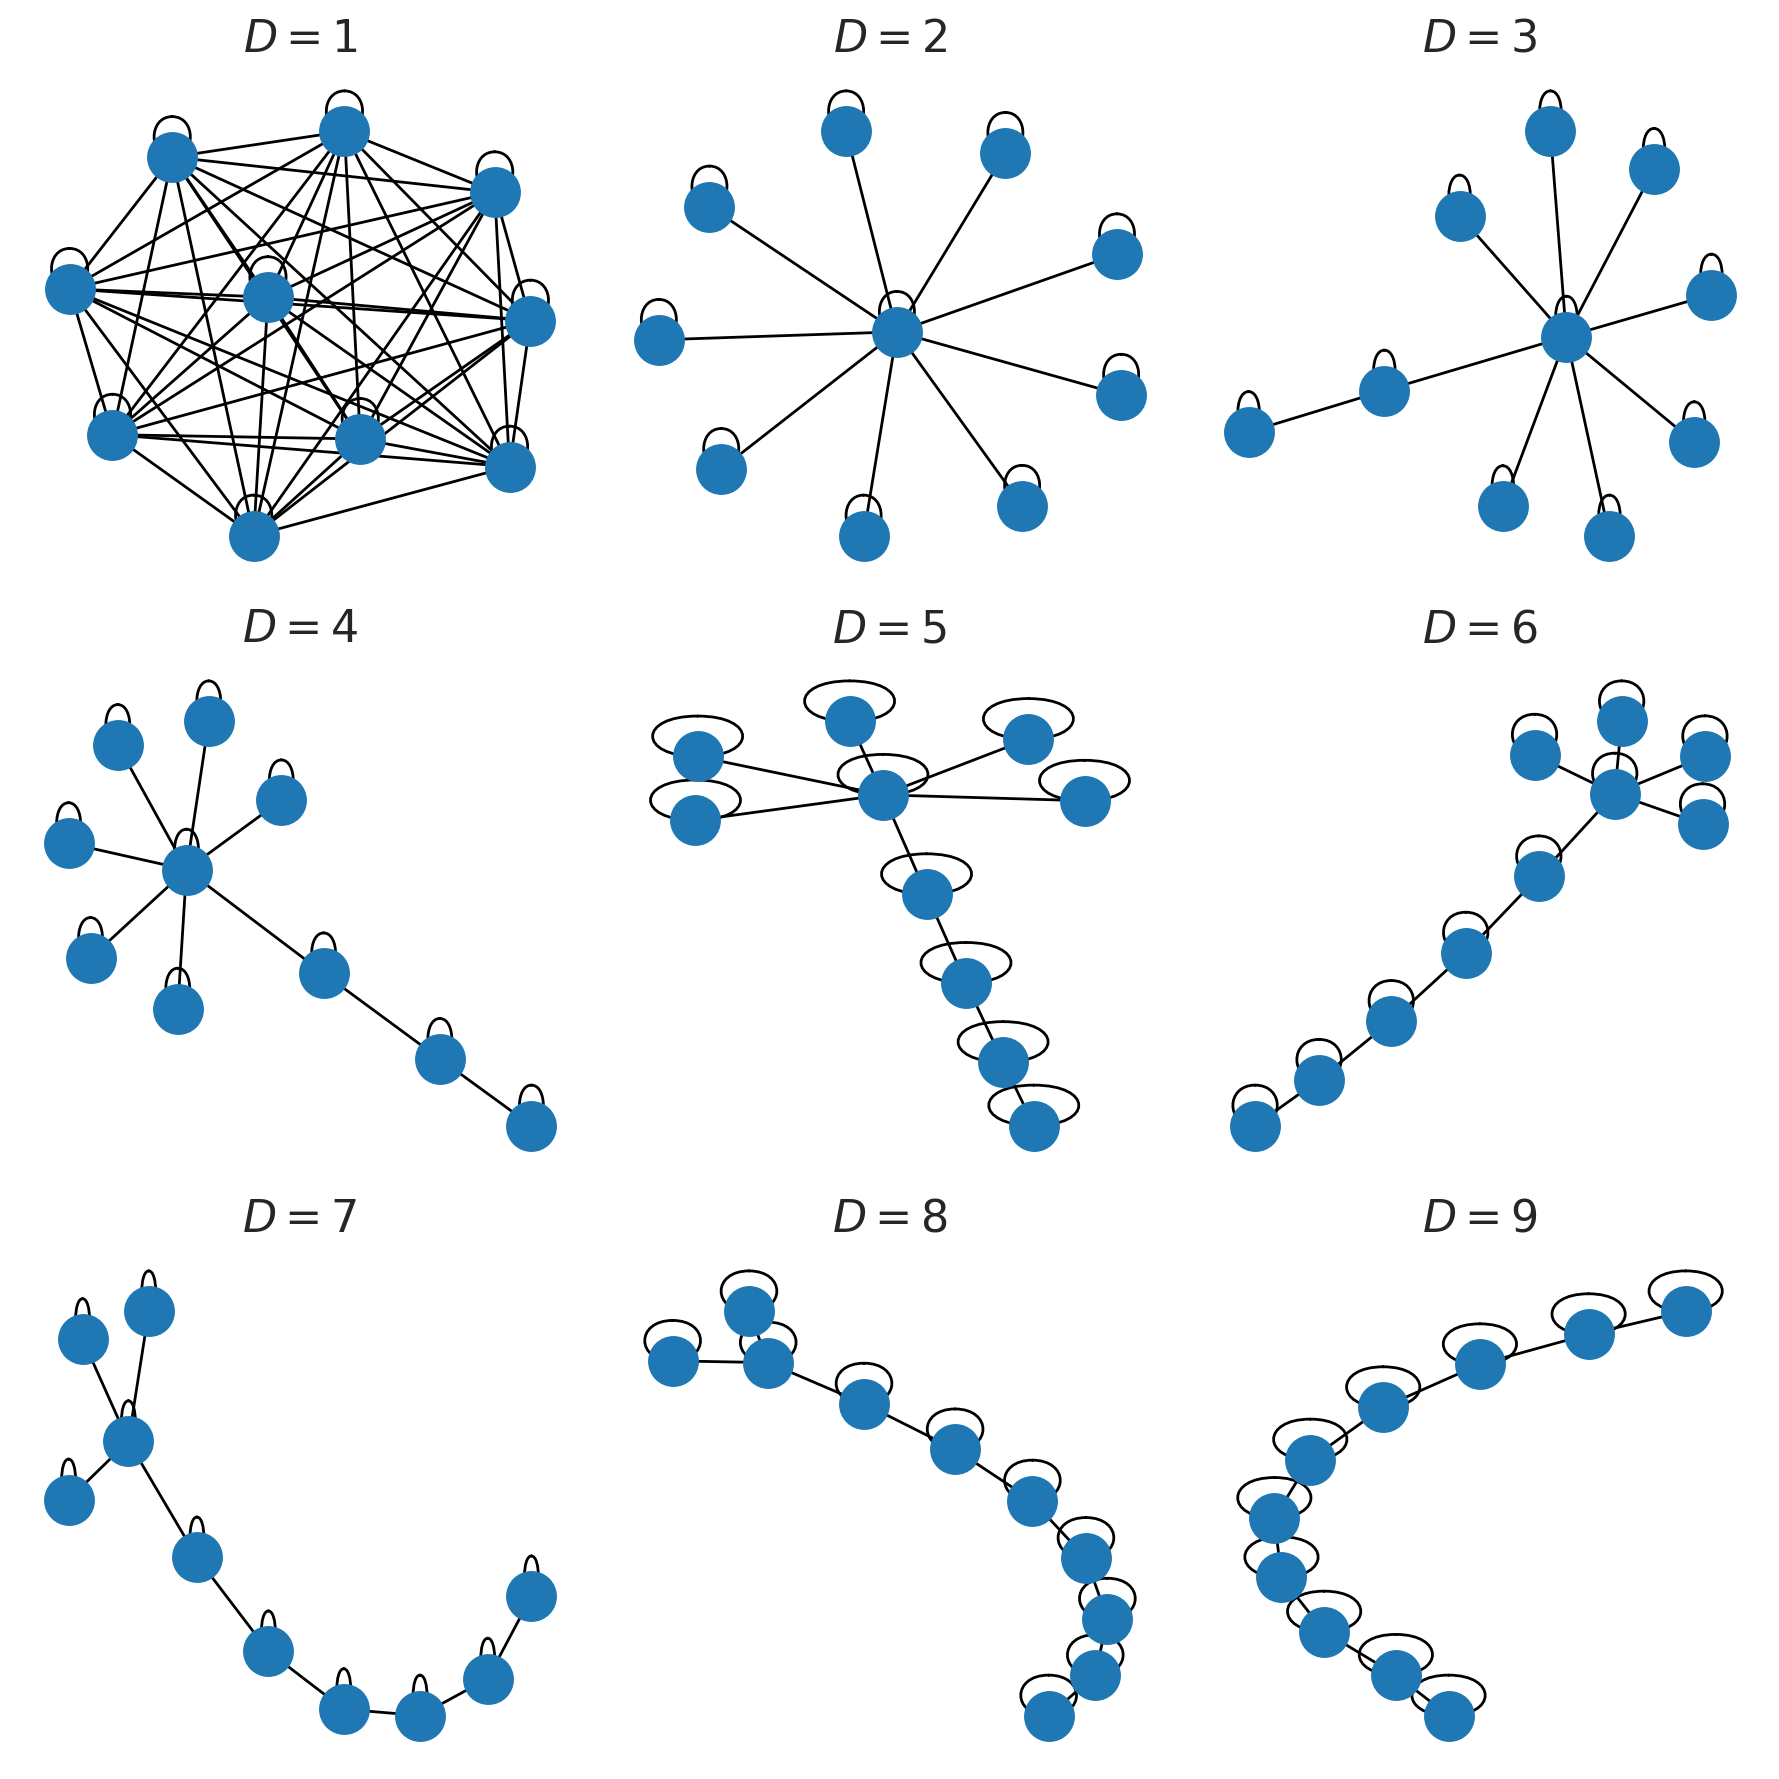

In [209]:
np.random.seed(SEED)
fig,axes = plt.subplots(3,3,figsize=(9, 9),dpi=200)
axes = axes.flatten()
for i in range(1,10):
    ax = axes[i-1]
    nx.draw(fix_diameter_graph(10,i),ax=ax)
    ax.set_title(r'$D={}$'.format(i),fontsize=16)
plt.tight_layout()
plt.savefig('Figures/IncreasingDIllustration.png')
plt.show()

In [233]:
n_nodes = 50
n_samples = 100

T=1000

init_node = 0

Ds = range(2,n_nodes+2,4)

np.random.seed(SEED)
for d in Ds:
    G = fix_diameter_graph(n_nodes,d)

    means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

    regrets = train_agent(n_samples,T,G,means,init_node,doubling_agent,parallelized=True)
    
    reg['$D={}$'.format(d)]=regrets

In [234]:
with open('Data/D_test.pkl', 'wb') as file:
    pkl.dump(reg,file)

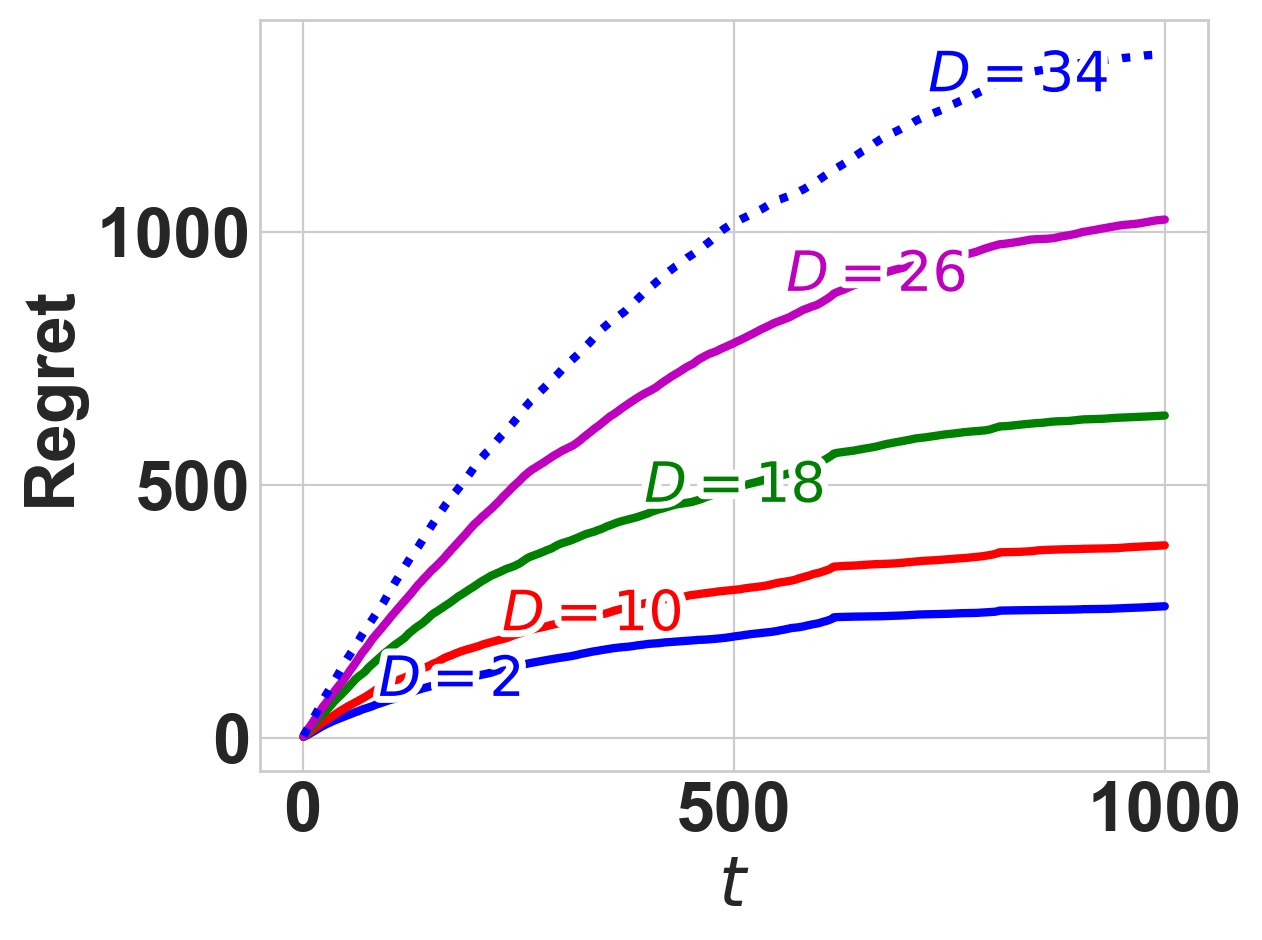

In [235]:

plt.rc('font', weight='bold')
plt.figure(dpi=200)


to_plot = {'$D={}$'.format(i):reg['$D={}$'.format(i)] for i in [2,10,18,26,34]}

plotRegrets([to_plot])

lines = plt.gca().get_lines()


labelLines(lines,align=False, zorder=2.5,fontsize=20)


plt.tight_layout()
plt.savefig('Figures/D_test.png')

plt.show()

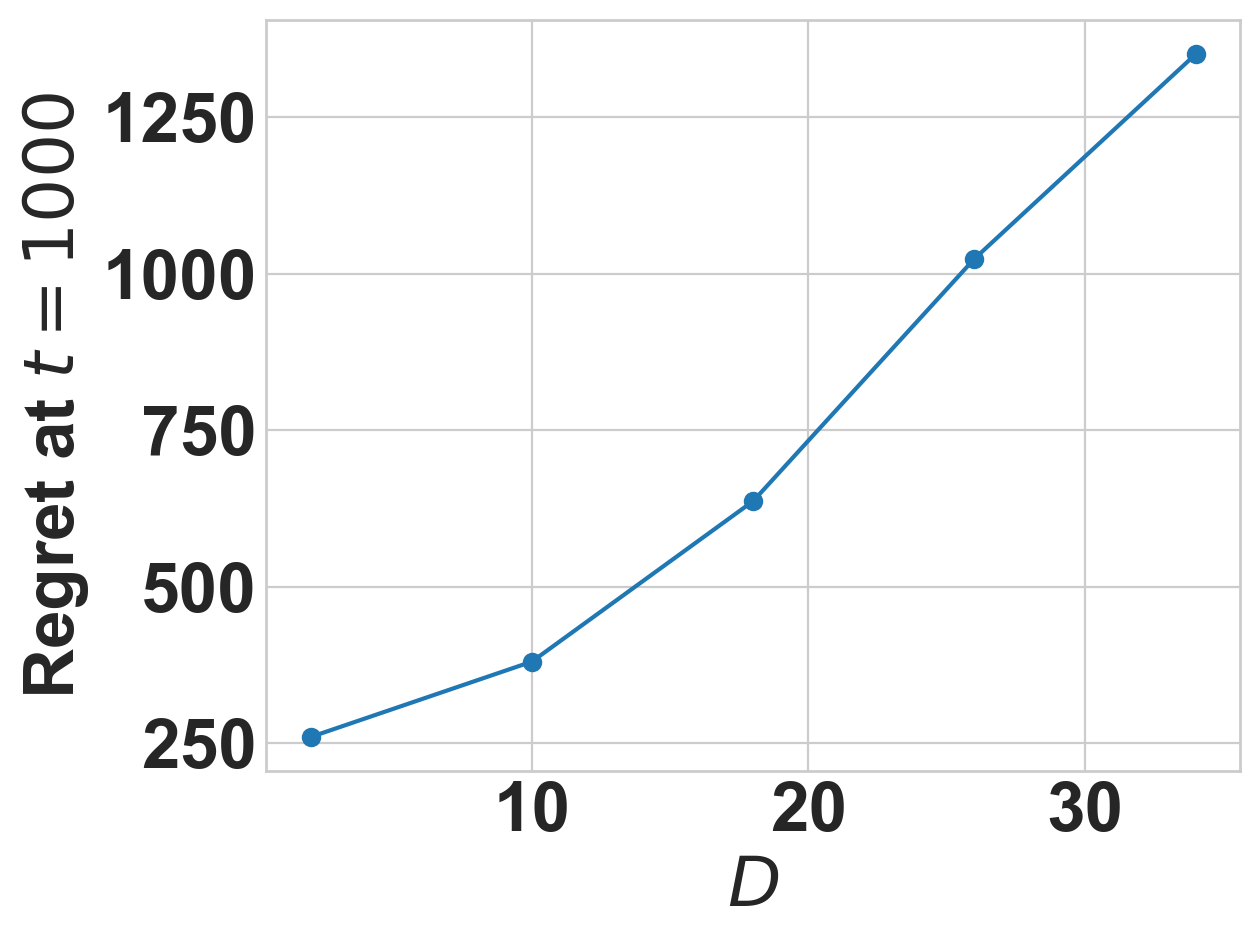

In [236]:

to_plot_D = [2,10,18,26,34]
R = [reg['$D={}$'.format(d)] for d in to_plot_D]
R = np.cumsum(R, axis=2)
R = np.mean(R, axis=1)

plt.figure(dpi=200)

plt.plot(to_plot_D,R[:,-1],marker='o')
plt.rc('font', weight='bold')

plt.xlabel(r"$D$",fontsize=25,weight = 'bold')
plt.ylabel(r'Regret at $t=1000$',fontsize=25,weight = 'bold')
plt.tick_params(labelsize=25)

plt.tight_layout()
plt.savefig('Figures/RvsD.png')
plt.show()